Dataset created successfully with 1000 samples!
   gender  math score  reading score  writing score  \
0  female          63             42             41   
1    male          61             77             64   
2  female          63             35             94   
3  female          69             91             84   
4  female          67             98             74   

  parental level of education  hours_studied_wk test_prep_course  
0           bachelor's degree                 3        completed  
1             master's degree                13        completed  
2                some college                11        completed  
3           bachelor's degree                19        completed  
4                 high school                12        completed  
--------------------------------------------------
--- Linear Regression (Predicting Math Score) ---
Mean Squared Error: 128.30
R² Score: 0.168
Cross-Validation R² (5-Fold Mean): 0.252 (±0.028)


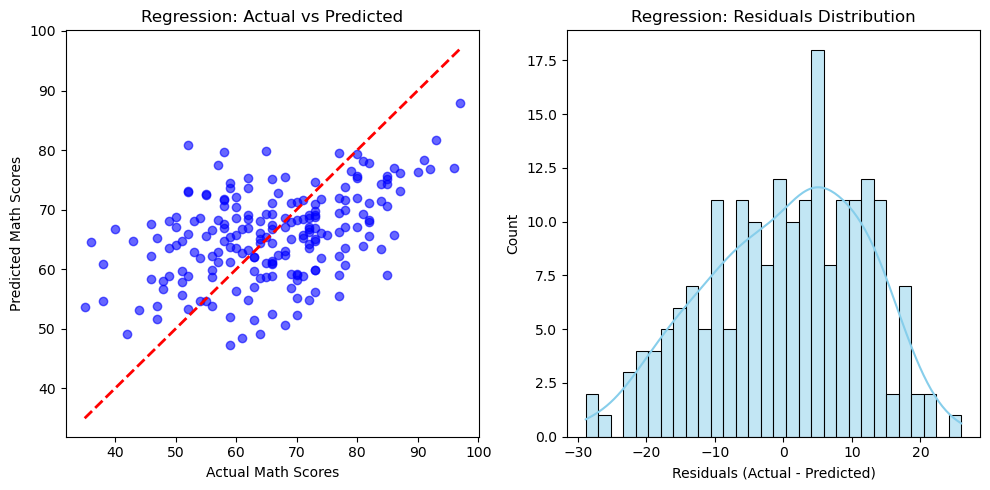


--- Logistic Regression (Pass/Fail Classification) ---
Accuracy: 0.650
Cross-Validation Accuracy (5-Fold Mean): 0.691 (±0.011)

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.38      0.41        64
           1       0.73      0.78      0.75       136

    accuracy                           0.65       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.64      0.65      0.64       200



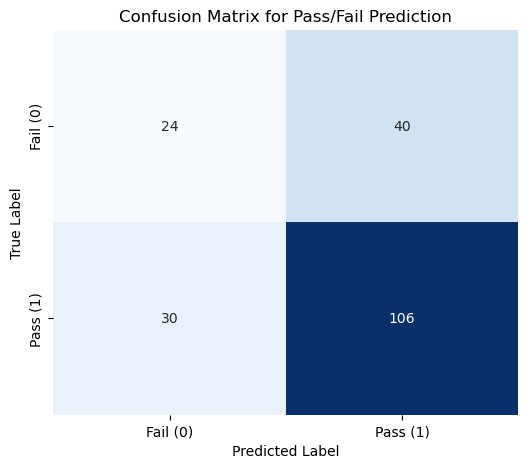

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

# ------------------------------------------------------------------
# 1. Scalable Synthetic Dataset Generation (IMPROVEMENT 1)
# Create a much larger dataset for meaningful results.
# ------------------------------------------------------------------
np.random.seed(42)
N_SAMPLES = 1000

# Generate synthetic data with broader feature categories
data = {
    "gender": np.random.choice(["female", "male"], N_SAMPLES),
    "math score": np.random.randint(30, 100, N_SAMPLES),
    "reading score": np.random.randint(35, 100, N_SAMPLES),
    "writing score": np.random.randint(30, 100, N_SAMPLES),
    "parental level of education": np.random.choice([
        "bachelor's degree", "some college", "master's degree",
        "associate's degree", "high school", "some high school"
    ], N_SAMPLES),
    # Simulate a moderate effect of study time and test prep
    "hours_studied_wk": np.random.randint(2, 20, N_SAMPLES),
    "test_prep_course": np.random.choice(["none", "completed"], N_SAMPLES, p=[0.6, 0.4])
}
df = pd.DataFrame(data)

# Adjust 'math score' to be influenced by other variables for realism
df['math score'] = (
    df['math score'] * 0.5 +
    df['reading score'] * 0.2 +
    df['writing score'] * 0.2 +
    df['hours_studied_wk'] * 0.5 +
    np.where(df['test_prep_course'] == 'completed', 5, 0) +
    np.random.normal(0, 5, N_SAMPLES)
).clip(0, 100).round().astype(int)


print(f"Dataset created successfully with {N_SAMPLES} samples!")
print(df.head())
print("-" * 50)


# ------------------------------------------------------------------
# 2. Feature Engineering (IMPROVEMENT 2)
# Create composite and interaction features.
# ------------------------------------------------------------------
df['Average_Score'] = (df['reading score'] + df['writing score']) / 2
# Interaction term: Does high study time benefit those with completed test prep?
df['Study_Prep_Interaction'] = df['hours_studied_wk'] * np.where(df['test_prep_course'] == 'completed', 1, 0)

# ------------------------------------------------------------------
# 3. Define Preprocessing Pipeline (IMPROVEMENT 3 - Robustness)
# Use ColumnTransformer to apply correct steps to different feature types.
# ------------------------------------------------------------------

# Define features sets
numerical_features = ['reading score', 'writing score', 'hours_studied_wk', 'Average_Score', 'Study_Prep_Interaction']
categorical_features = ['gender', 'parental level of education', 'test_prep_course']

# Create Preprocessing Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Scaling numerical data
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Encoding categorical data
    ],
    remainder='passthrough'
)

# ------------------------------------------------------------------
# 4. Linear Regression Model (Predicting 'math score' - REGRESSION)
# ------------------------------------------------------------------
print("--- Linear Regression (Predicting Math Score) ---")

X_reg = df.drop('math score', axis=1)
y_reg = df['math score']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Create and train the full Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test_reg)

# Evaluate
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

# Cross-Validation (IMPROVEMENT 4)
cv_scores = cross_val_score(reg_pipeline, X_reg, y_reg, cv=5, scoring='r2')

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"Cross-Validation R² (5-Fold Mean): {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Visualization: Predicted vs. Actual Scores (IMPROVEMENT 5)
plt.figure(figsize=(10, 5))

# Plot 1: Actual vs. Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg, color='blue', alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel("Actual Math Scores")
plt.ylabel("Predicted Math Scores")
plt.title("Regression: Actual vs Predicted")

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_test_reg - y_pred_reg
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Regression: Residuals Distribution")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 5. Logistic Regression Model (Pass/Fail - CLASSIFICATION)
# ------------------------------------------------------------------
print("\n" + "=" * 50)
print("--- Logistic Regression (Pass/Fail Classification) ---")

# Target variable: 1 if score >= 60, 0 otherwise
df['pass_math'] = np.where(df['math score'] >= 60, 1, 0)

X_clf = df.drop(['math score', 'pass_math'], axis=1)
y_clf = df['pass_math']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Create and train the full Classification Pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
clf_pipeline.fit(X_train_clf, y_train_clf)
y_pred_clf = clf_pipeline.predict(X_test_clf)

# Evaluate
accuracy = accuracy_score(y_test_clf, y_pred_clf)
cv_scores_clf = cross_val_score(clf_pipeline, X_clf, y_clf, cv=5, scoring='accuracy')
cm = confusion_matrix(y_test_clf, y_pred_clf)

print(f"Accuracy: {accuracy:.3f}")
print(f"Cross-Validation Accuracy (5-Fold Mean): {cv_scores_clf.mean():.3f} (±{cv_scores_clf.std():.3f})")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_clf))

# Visualization: Confusion Matrix (IMPROVEMENT 5)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fail (0)', 'Pass (1)'], yticklabels=['Fail (0)', 'Pass (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Pass/Fail Prediction")
plt.show()
